# Showcasing how to evaluate an experiment

### Load assignation data

In [64]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv('Data/experiment_universe_full.csv')
df.head()

,CLIENT_ID,AGE,INCOME,SPENDING,GENDER,TYPE,AGE_WINSOR,AGE_QUARTILES,INCOME_WINSOR,INCOME_QUARTILES,...,treat,TYPE_A,TYPE_B,TYPE_C,TYPE_A.1,TYPE_B.1,TYPE_C.1,TYPE_A.2,TYPE_B.2,TYPE_C.2
0,10137,32.10,0.00,2377.77,NaN,A,32.10,19 to 40,0.00,"0 to 63,352",...,1,True,False,False,True,False,False,True,False,False
1,54012,38.18,42701.98,4391.79,NaN,A,38.18,19 to 40,42701.98,"0 to 63,352",...,2,True,False,False,True,False,False,True,False,False
2,23168,31.33,53771.57,26832.03,NaN,A,31.33,19 to 40,53771.57,"0 to 63,352",...,2,True,False,False,True,False,False,True,False,False
3,26682,32.51,43948.33,22770.41,NaN,A,32.51,19 to 40,43948.33,"0 to 63,352",...,1,True,False,False,True,False,False,True,False,False
4,28791,15.00,61190.10,26084.24,NaN,A,18.88,19 to 40,61190.10,"0 to 63,352",...,1,True,False,False,True,False,False,True,False,False


### Create fake outputs

Assume you want to evaluate the effect of your treatments over posterior spending, app activity and posterior income.

In [74]:

# Create dummy variables for treatment groups
df['D_treat1'] = (df['treat'] == 1).astype(int)
df['D_treat2'] = (df['treat'] == 2).astype(int)

# Create POST_SPENDING column based on the specified conditions and ensure non-negativity
df['POST_SPENDING'] = df['SPENDING'] + \
                      np.random.normal(700, 20, size=df.shape[0]) * df['D_treat1'] + \
                      np.random.normal(500, 10, size=df.shape[0]) * df['D_treat2'] + \
                      np.random.normal(0, 300, size=df.shape[0])
df['POST_SPENDING'] = df['POST_SPENDING'].clip(lower=0)

# Create APP_ACT with a base normal distribution and ensure non-negativity
df['APP_ACT'] = np.random.normal(5, 2, size=df.shape[0])
# Adjust for spending and age effects
spending_effect = (df['SPENDING'] - df['SPENDING'].mean()) / df['SPENDING'].std()
age_effect = (df['AGE'] - df['AGE'].mean()) / df['AGE'].std()
df['APP_ACT'] += spending_effect * 0.5 - age_effect * 0.5
# Add treatment noise for those under 25 and ensure non-negativity
additional_noise_treat1 = np.zeros(df.shape[0])
additional_noise_treat2 = np.zeros(df.shape[0])
age_under_25_indices = df['AGE'] < 25
additional_noise_treat1[age_under_25_indices] = np.random.normal(2, 0.5, size=age_under_25_indices.sum())
additional_noise_treat2[age_under_25_indices] = np.random.normal(1, 0.25, size=age_under_25_indices.sum())
df['APP_ACT'] += (additional_noise_treat1 * df['D_treat1']) + (additional_noise_treat2 * df['D_treat2'])
df['APP_ACT'] = df['APP_ACT'].clip(lower=0)

# Create POST_INCOME column with INCOME plus some random noise and ensure non-negativity
df['POST_INCOME'] = df['INCOME'] + np.random.normal(0, 600, size=df.shape[0])
df['POST_INCOME'] = df['POST_INCOME'].clip(lower=0)


df.head()

,CLIENT_ID,AGE,INCOME,SPENDING,GENDER,TYPE,AGE_WINSOR,AGE_QUARTILES,INCOME_WINSOR,INCOME_QUARTILES,...,TYPE_B.1,TYPE_C.1,TYPE_A.2,TYPE_B.2,TYPE_C.2,D_treat1,D_treat2,POST_SPENDING,APP_ACT,POST_INCOME
0,10137,32.10,0.00,2377.77,NaN,A,32.10,19 to 40,0.00,"0 to 63,352",...,False,False,True,False,False,1,0,2987.223473,4.180625,174.513508
1,54012,38.18,42701.98,4391.79,NaN,A,38.18,19 to 40,42701.98,"0 to 63,352",...,False,False,True,False,False,0,1,4738.947979,5.751850,42500.499951
2,23168,31.33,53771.57,26832.03,NaN,A,31.33,19 to 40,53771.57,"0 to 63,352",...,False,False,True,False,False,0,1,27359.634804,6.229669,54362.093016
3,26682,32.51,43948.33,22770.41,NaN,A,32.51,19 to 40,43948.33,"0 to 63,352",...,False,False,True,False,False,1,0,23873.450917,8.560525,44635.803601
4,28791,15.00,61190.10,26084.24,NaN,A,18.88,19 to 40,61190.10,"0 to 63,352",...,False,False,True,False,False,1,0,26545.766701,6.747487,60963.512767


### Evaluation function

In [75]:
def eval_func(data, treat, output):
    # Identify the control group
    control_data = data[data[treat] == 0][output]
    control_mean = control_data.mean()
    
    # List to collect each group's results, starting with the control group
    results_list = [{'group': 0, 'mean_diff': control_mean, 'ci_lower': np.nan, 'ci_upper': np.nan}]
    
    # Iterate over each group except the control group
    for group in data[treat].unique():
        if group != 0:
            treatment_data = data[data[treat] == group][output]
            
            # Calculate mean difference
            mean_diff = treatment_data.mean() - control_mean
            
            # Calculate pooled standard deviation (for independent samples t-test)
            sd_pooled = np.sqrt(((control_data.std() ** 2) / len(control_data)) + 
                                ((treatment_data.std() ** 2) / len(treatment_data)))
            
            # Calculate 95% CI for the mean difference
            ci_lower = mean_diff - 1.96 * sd_pooled
            ci_upper = mean_diff + 1.96 * sd_pooled
            
            # Collect the results
            results_list.append({'group': group,
                                 'mean_diff': mean_diff,
                                 'ci_lower': ci_lower,
                                 'ci_upper': ci_upper})
    
    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list)
    return results_df

In [91]:
def plot_ci_ranges(df, title = ''):
    # Exclude the control group from the plot
    df_treatments_only = df[df['group'] != 0]

    # Create a new figure and axis
    fig, ax = plt.subplots()
    
    # Set the face color to white and remove grid
    ax.set_facecolor('white')
    ax.grid(False)

    # Define a color palette with enough colors for each treatment group
    colors = plt.cm.tab10(np.linspace(0, 1, len(df_treatments_only)))

    # Plot vertical lines for CI ranges for each treatment group with horizontal caps
    for i, (index, row) in enumerate(df_treatments_only.iterrows()):
        color = colors[i]
        ax.errorbar(x=row['group'], y=row['mean_diff'], 
                    yerr=[[row['mean_diff'] - row['ci_lower']], [row['ci_upper'] - row['mean_diff']]], 
                    fmt='o', color=color, capsize=5, capthick=2, ecolor=color)

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='gray', lw=1)
    
    # Remove top and right axes lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set labels and title
    ax.set_xlabel('Treatment Group')
    ax.set_ylabel('CI for treatment effect')
    ax.set_title(title)

    # Improve x-axis: set ticks and labels to clearly show each treatment group
    ax.set_xticks(df_treatments_only['group'].values)
    ax.set_xticklabels(df_treatments_only['group'].values)

    # Show plot
    plt.show()

In [120]:
def plot_ci_ranges(df, title=''):
    # Retrieve the control mean and round it
    control_mean = round(df[df['group'] == 0]['mean_diff'].iloc[0], 2)

    # Exclude the control group from the plot
    df_treatments_only = df[df['group'] != 0]

    # Create a new figure and axis
    fig, ax = plt.subplots()
    
    # Set the face color to white and remove grid
    ax.set_facecolor('white')
    ax.grid(False)

    # Define a color palette with enough colors for each treatment group
    colors = plt.cm.tab10(np.linspace(0, 1, len(df_treatments_only)))

    # Plot vertical lines for CI ranges for each treatment group with horizontal caps
    for i, (index, row) in enumerate(df_treatments_only.iterrows()):
        color = colors[i]
        ax.errorbar(x=row['group'], y=row['mean_diff'], 
                    yerr=[[row['mean_diff'] - row['ci_lower']], [row['ci_upper'] - row['mean_diff']]], 
                    fmt='o', color=color, capsize=5, capthick=2, ecolor=color)

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='gray', lw=1)
    
    # Remove top and right axes lines and make left axis line invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('gray')

    # Print the control mean near the x-axis
    # Adjust the x and y parameters as needed to position the text appropriately
    ax.text(x=df_treatments_only['group'].min(), y=ax.get_ylim()[0], s=f"Control mean: {control_mean}", verticalalignment='bottom', horizontalalignment='left')

    # Set labels and title
    ax.set_xlabel('Treatment Group')
    ax.set_ylabel('CI for treatment effect')
    ax.set_title(title)

    # Improve x-axis: set ticks and labels to clearly show each treatment group
    ax.set_xticks(df_treatments_only['group'].values)
    ax.set_xticklabels(df_treatments_only['group'].values)

    # Show plot
    plt.show()

In [121]:
post_income_effect = eval_func(data = df, treat = 'treat', output = 'POST_INCOME')
post_income_effect

,group,mean_diff,ci_lower,ci_upper
0,0,100842.473683,NaN,NaN
1,1,36.677900,-1069.129032,1142.484832
2,2,83.833237,-1017.677281,1185.343755


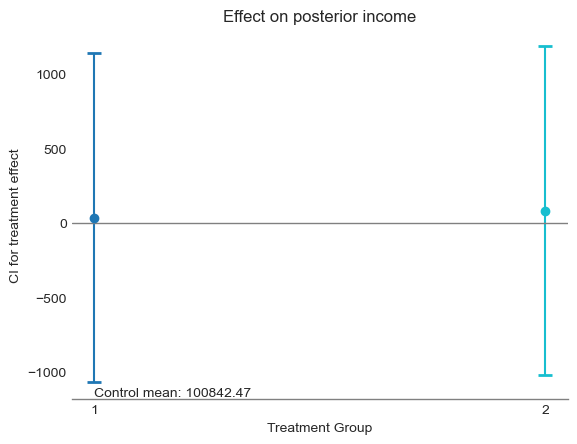

In [122]:
plot_ci_ranges(post_income_effect, title = 'Effect on posterior income')

In [123]:
post_spending_effect = eval_func(data = df, treat = 'treat', output = 'POST_SPENDING')
post_spending_effect

,group,mean_diff,ci_lower,ci_upper
0,0,20507.083423,NaN,NaN
1,1,666.330115,373.069102,959.591129
2,2,520.404828,226.419328,814.390328


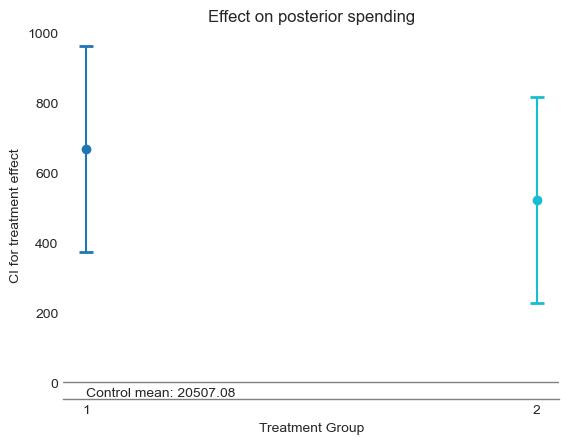

In [124]:
plot_ci_ranges(post_spending_effect, title = 'Effect on posterior spending')

In [125]:
app_act_effect = eval_func(data = df, treat = 'treat', output = 'APP_ACT')
app_act_effect

,group,mean_diff,ci_lower,ci_upper
0,0,4.986161,NaN,NaN
1,1,0.120526,0.075215,0.165837
2,2,0.055450,0.010809,0.100090


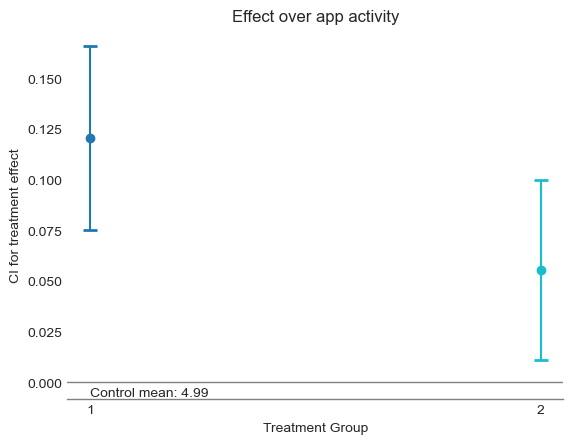

In [126]:
plot_ci_ranges(app_act_effect, title = 'Effect over app activity')

### Check for heterogeneities

In [127]:
df['AGE_QUARTILES'].unique()

array(['19 to 40', '40 to 50', '50 to 60', '60 to 85'], dtype=object)

In [128]:
app_act_effect_quart1 = eval_func(data = df[df['AGE_QUARTILES'] == '19 to 40'], treat = 'treat', output = 'APP_ACT')
app_act_effect_quart1

,group,mean_diff,ci_lower,ci_upper
0,0,5.352448,NaN,NaN
1,1,0.414508,0.321032,0.507984
2,2,0.208864,0.120681,0.297046


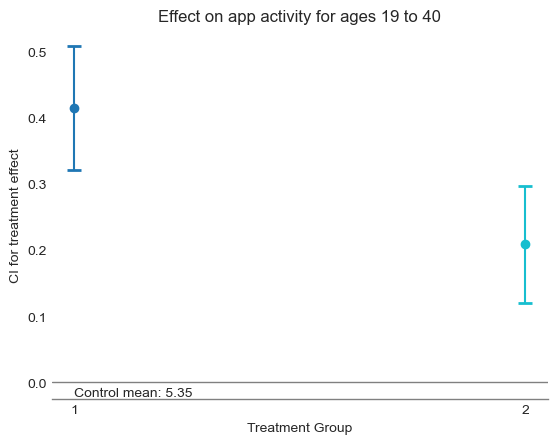

In [129]:
plot_ci_ranges(app_act_effect_quart1, 'Effect on app activity for ages 19 to 40')

In [130]:
app_act_effect_quart2 = eval_func(data = df[df['AGE_QUARTILES'] == '40 to 50'], treat = 'treat', output = 'APP_ACT')
app_act_effect_quart2

,group,mean_diff,ci_lower,ci_upper
0,0,5.081766,NaN,NaN
1,1,0.004374,-0.081885,0.090634
2,2,0.023401,-0.063224,0.110026


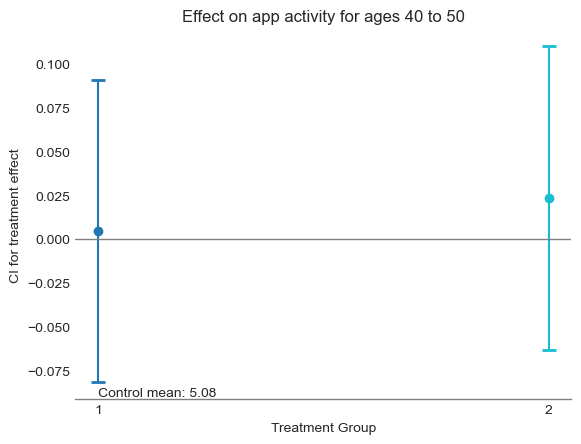

In [131]:
plot_ci_ranges(app_act_effect_quart2, 'Effect on app activity for ages 40 to 50')

In [132]:
app_act_effect_quart3 = eval_func(data = df[df['AGE_QUARTILES'] == '50 to 60'], treat = 'treat', output = 'APP_ACT')
app_act_effect_quart3

,group,mean_diff,ci_lower,ci_upper
0,0,4.898169,NaN,NaN
1,2,-0.021893,-0.111183,0.067397
2,1,0.069780,-0.018618,0.158178


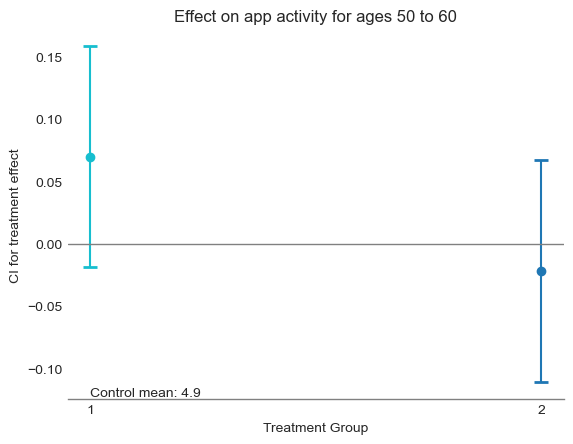

In [133]:
plot_ci_ranges(app_act_effect_quart3, 'Effect on app activity for ages 50 to 60')

In [134]:
app_act_effect_quart4 = eval_func(data = df[df['AGE_QUARTILES'] == '60 to 85'], treat = 'treat', output = 'APP_ACT')
app_act_effect_quart4

,group,mean_diff,ci_lower,ci_upper
0,0,4.611569,NaN,NaN
1,2,0.010453,-0.078035,0.098940
2,1,-0.002699,-0.090564,0.085166


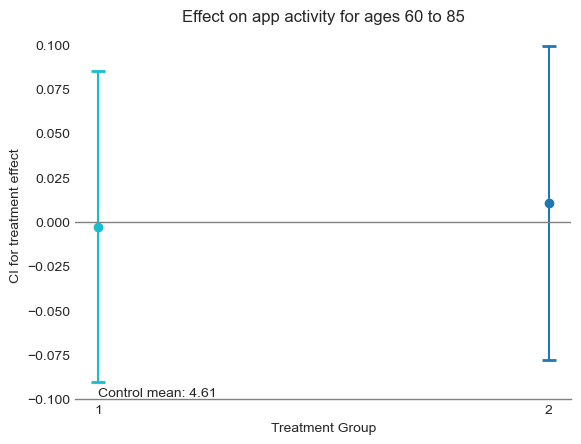

In [135]:
plot_ci_ranges(app_act_effect_quart4, 'Effect on app activity for ages 60 to 85')

Clearly, the effect over app activity is limited to the first age quartile. 